# Le changement climatique peut il être observé dans les Alpes?


## Introduction


Dans cette recherche, on se demande si le changement climatique est visible dans les Alpes et nous mettrons en lien les observations avec les analyses des flux hydrométriques (= le force du courant dans les rivières) dans cette région. 

Pour ce faire nous allons commencer par étudier l'évolution de la météo au cours des dernières décennies. Météo France, l'organisme national de météorologie en France, a déposé des données climatologiques par département avec de nombreux paramètres disponibles sur le site [data.gouv](https://www.data.gouv.fr/fr/datasets/donnees-climatologiques-de-base-quotidiennes/).

Dans un second temps, nous étudierons l'évolution des débits de l'Arve (une rivière) en lien avec le changement climatique et la fonte des glaciers aux alentours du Mont-Blanc (un massif *relativement* connu des Alpes).

## Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')


# PARTIE 1: Données climatiques de Météo France

## Chargement du jeu de données 

Récupérez les données publiques françaises disponibles sur le site [data.gouv](https://www.data.gouv.fr/fr/datasets/donnees-climatologiques-de-base-quotidiennes/), qui concernent la météo quotidienne en Haute-Savoie (département n°74, où se trouve le Mont-Blanc) entre 1950 et 2022. .



In [2]:
meteo = pd.read_csv("Q_74_previous-1950-2023_RR-T-Vent.csv" , sep=";")

Aperçu des données

In [3]:
meteo.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,74001001,ABONDANCE,46.2845,6.734167,947,19500101,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74001001,ABONDANCE,46.2845,6.734167,947,19500102,10.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74001001,ABONDANCE,46.2845,6.734167,947,19500103,48.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74001001,ABONDANCE,46.2845,6.734167,947,19500104,20.4,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74001001,ABONDANCE,46.2845,6.734167,947,19500105,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration des données

Dans le cadre de cette analyse, une exploration préliminaire des données a été réalisée afin de mieux comprendre la structure de la table meteo et d'en tirer des informations clés.

<b>Analyse des dimensions et du contenu :</b>
<ul>
    <li><b>Dimensions de la table </b>: La table meteo a été inspectée pour déterminer son nombre de lignes et de colonnes, ce qui donne une idée du volume de données disponibles.</li>
    <li><b>Nombre de postes météorologiques </b>: Un comptage distinct des postes météorologiques a été effectué pour identifier combien de stations différentes sont représentées dans l'ensemble de données.</li>
</ul>



In [4]:
dim = meteo.shape
postes = meteo["NUM_POSTE"].nunique()

In [5]:
print("la dimention de meteo est : " , dim)

la dimention de meteo est :  (1294509, 58)


In [6]:
print("il y a ",postes," postes")

il y a  142  postes


## Gestion des valeurs manquantes et filtration


<p><b>comme on va étudier l’évolution de la température et des précipitations depuis les années 1950 dans les Alpes donc on garde les colonnes suivantes : </b> </p>
<ul>
  <li>NUM_POST et NNOM_USUEL : pour identifier le poste</li>
  <li>LAT et LON et ALTI : latitude et longitude et altitude : pour localiser le poste</li>
  <li>AAAAMMJJ : la date</li>
  <li>RR : quantite de précipitation tombé en 24 heures</li>
  <li>TN : température minimale sous abri (en Â°C et 1/10)</li>
  <li>TX : température maximale sous abri (en Â°C et 1/10)</li>
</ul>

In [7]:
columns_of_interest = ['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'TN', 'TX']

<b>Étapes pour traiter les valeurs manquantes</b> :<br>
Comprendre la nature des valeurs manquantes
Avant de décider quoi faire, identifiez :
<ul>
    <li>La proportion des valeurs manquantes.</li>
    <li>Les colonnes concernées.</li>
    <li>Si ces valeurs manquantes sont aléatoires ou ont une cause identifiable.</li>
</ul>

In [8]:
meteo_cleaned = meteo[columns_of_interest].dropna()

In [9]:
meteo_cleaned.isnull().mean() * 100

NUM_POSTE    0.0
NOM_USUEL    0.0
LAT          0.0
LON          0.0
ALTI         0.0
AAAAMMJJ     0.0
RR           0.0
TN           0.0
TX           0.0
dtype: float64

on constate que certaines colonnes, notamment TN (température minimale) et TX (température maximale), contenaient environ 40 % de valeurs manquantes. Pour préserver au maximum l'information disponible sans introduire de biais excessif, on utilise la méthode de remplacement par la moyenne. Cette approche permet de maintenir une cohérence statistique en remplissant les valeurs manquantes avec une estimation représentative, tout en évitant de supprimer une portion importante des données qui aurait pu réduire la robustesse des analyses ultérieures.

In [10]:
#from sklearn.impute import SimpleImputer

#columns_to_impute = ['RR', 'TN', 'TX']  

# Création d'un SimpleImputer pour la moyenne
#imputer = SimpleImputer(strategy='mean')

# Imputation des colonnes sélectionnées
#meteo_cleaned[columns_to_impute] = imputer.fit_transform(meteo_cleaned[columns_to_impute])

In [11]:
# Analyse statistique des données
statistics = meteo_cleaned.describe()

# Affichage des informations statistiques de base
print("Statistiques de base:")
print(statistics) 

Statistiques de base:
          NUM_POSTE            LAT            LON           ALTI  \
count  7.363550e+05  736355.000000  736355.000000  736355.000000   
mean   7.414354e+07      46.027265       6.470677     831.535948   
std    9.008964e+04       0.160267       0.279305     375.695165   
min    7.400100e+07      45.713000       5.841667     345.000000   
25%    7.408000e+07      45.898333       6.275667     452.000000   
50%    7.413400e+07      46.008333       6.471833     790.000000   
75%    7.422500e+07      46.128667       6.670333    1159.000000   
max    7.429000e+07      46.396500       6.970833    2196.000000   

           AAAAMMJJ             RR             TN             TX  
count  7.363550e+05  736355.000000  736355.000000  736355.000000  
mean   1.995411e+07       3.813527       3.860550      13.442790  
std    1.928530e+05       8.199972       7.046152       8.998763  
min    1.950010e+07       0.000000     -30.600000     -20.000000  
25%    1.981050e+07       0.00

In [12]:
stations = meteo_cleaned["NUM_POSTE"].nunique()
print("il reste ",stations, "stations")

il reste  93 stations


## Analyse des données

### Tendances annuelles

<h4>1) On va Transformer la colonne date pour que on puissie l’exploiter facilement</h4>

In [13]:
meteo_cleaned['AAAAMMJJ'] = pd.to_datetime(meteo_cleaned['AAAAMMJJ'], format='%Y%m%d')

meteo_cleaned['annee'] = meteo_cleaned['AAAAMMJJ'].dt.year
meteo_cleaned['mois'] = meteo_cleaned['AAAAMMJJ'].dt.month
meteo_cleaned['jour'] = meteo_cleaned['AAAAMMJJ'].dt.day

In [14]:
meteo_cleaned.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,TN,TX,annee,mois,jour
2922,74001001,ABONDANCE,46.2845,6.734167,947,1958-01-01,0.0,-9.6,0.6,1958,1,1
2923,74001001,ABONDANCE,46.2845,6.734167,947,1958-01-02,0.0,-7.0,3.8,1958,1,2
2924,74001001,ABONDANCE,46.2845,6.734167,947,1958-01-03,0.0,-5.0,4.2,1958,1,3
2925,74001001,ABONDANCE,46.2845,6.734167,947,1958-01-04,2.0,-8.0,1.0,1958,1,4
2926,74001001,ABONDANCE,46.2845,6.734167,947,1958-01-05,25.5,-0.4,6.8,1958,1,5


<h4>2) On Calcule les températures et précipitations moyennes annuelles</h4>

In [15]:
tx_annuelles = meteo_cleaned.groupby("annee")["TX"].mean()

In [16]:
tx_annuelles.head()

annee
1950    13.781780
1951    13.805429
1952    14.079945
1953    14.171604
1954    13.316830
Name: TX, dtype: float64

In [17]:
tn_annuelles = meteo_cleaned.groupby("annee")["TN"].mean()

In [18]:
tn_annuelles.head()

annee
1950    3.212042
1951    3.937942
1952    3.376021
1953    3.253703
1954    3.388845
Name: TN, dtype: float64

In [19]:
rr_annuelles = meteo_cleaned.groupby("annee")["RR"].mean()

In [20]:
rr_annuelles.head()

annee
1950    3.659686
1951    4.162963
1952    4.687792
1953    2.557505
1954    3.986849
Name: RR, dtype: float64

In [21]:
moyenne_annuelles = meteo_cleaned.groupby('annee').agg(
    TN_annuelles=('TN', 'mean'),
    TX_annuelles=('TX', 'mean'),
    RR_annuelles=('RR', 'mean')
).reset_index()

# Affichez les moyennes annuelles
print(moyenne_annuelles.head())

   annee  TN_annuelles  TX_annuelles  RR_annuelles
0   1950      3.212042     13.781780      3.659686
1   1951      3.937942     13.805429      4.162963
2   1952      3.376021     14.079945      4.687792
3   1953      3.253703     14.171604      2.557505
4   1954      3.388845     13.316830      3.986849


In [22]:
moyenne_annuelles["Temp_annuelles"] = ((moyenne_annuelles["TN_annuelles"]+ moyenne_annuelles["TX_annuelles"])/2)

In [23]:
moyenne_annuelles.head()

,annee,TN_annuelles,TX_annuelles,RR_annuelles,Temp_annuelles
0,1950,3.212042,13.781780,3.659686,8.496911
1,1951,3.937942,13.805429,4.162963,8.871686
2,1952,3.376021,14.079945,4.687792,8.727983
3,1953,3.253703,14.171604,2.557505,8.712653
4,1954,3.388845,13.316830,3.986849,8.352838


<h4>3) On observe l'évolution de la température moyenne annuelle au cours du temps.s</h4>

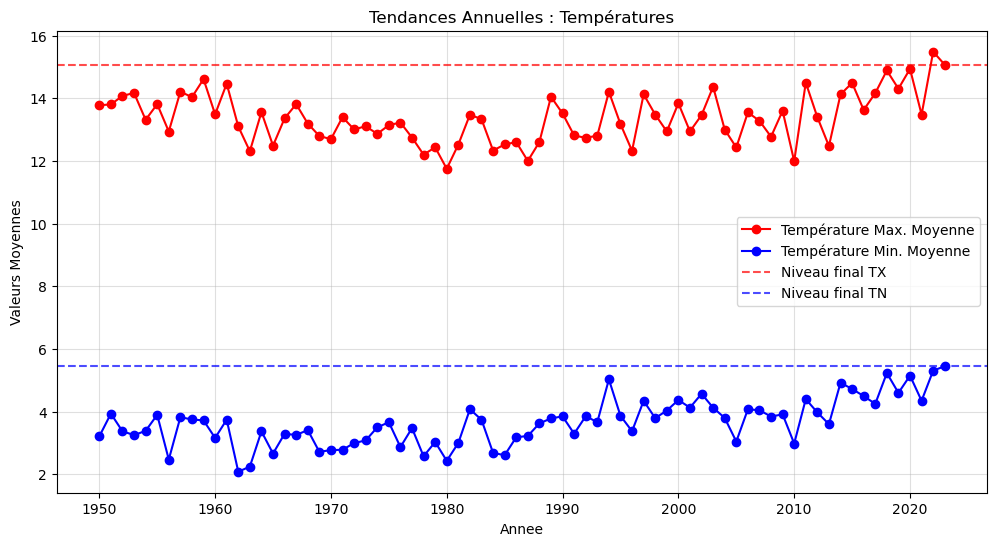

In [24]:
plt.figure(figsize=(12, 6))

# Températures maximales et minimales
plt.plot(moyenne_annuelles['annee'], moyenne_annuelles['TX_annuelles'], label='Température Max. Moyenne', color='red', marker='o')
plt.plot(moyenne_annuelles['annee'], moyenne_annuelles['TN_annuelles'], label='Température Min. Moyenne', color='blue', marker='o')

x_last = moyenne_annuelles['annee'].iloc[-1]
y_last_tx = moyenne_annuelles['TX_annuelles'].iloc[-1]
y_last_tn = moyenne_annuelles['TN_annuelles'].iloc[-1]

# Ajouter les lignes horizontales
plt.axhline(y=y_last_tx, color='red', linestyle='--', alpha=0.7, label="Niveau final TX")
plt.axhline(y=y_last_tn, color='blue', linestyle='--', alpha=0.7, label="Niveau final TN")


# Esthétique
plt.title("Tendances Annuelles : Températures")
plt.xlabel("Annee")
plt.ylabel("Valeurs Moyennes")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

<h5>Observation : </h5>
L'analyse des variations de la température moyenne annuelle montre une tendance générale à la hausse au fil du temps, malgré des fluctuations intermédiaires caractérisées par des phases de hausse suivies de légères baisses.


<h3>4) la régression linéaire pour estimer l’évolution des températures et précipitations moyennes annuelles</h3>

In [25]:
# Variables explicatives (année)
X = moyenne_annuelles['annee'].values.reshape(-1, 1)

# Régression pour les températures minimales
y_tn = moyenne_annuelles['TN_annuelles']
model_tn = LinearRegression()
model_tn.fit(X, y_tn)

# Régression pour les températures maximales
y_tx = moyenne_annuelles['TX_annuelles']
model_tx = LinearRegression()
model_tx.fit(X, y_tx)

# Régression pour les températures maximales
y_temp = moyenne_annuelles['Temp_annuelles']
model_temp = LinearRegression()
model_temp.fit(X, y_temp)

# Régression pour les précipitations
y_rr = moyenne_annuelles['RR_annuelles']
model_rr = LinearRegression()
model_rr.fit(X, y_rr)

# Affichez les coefficients et intercepts
print("Évolution des températures minimales :")
print(f"Coefficient : {model_tn.coef_[0]}, Intercept : {model_tn.intercept_}")

print("\nÉvolution des températures maximales :")
print(f"Coefficient : {model_tx.coef_[0]}, Intercept : {model_tx.intercept_}")

print("\nÉvolution des températures moyennes :")
print(f"Coefficient : {model_temp.coef_[0]}, Intercept : {model_temp.intercept_}")

print("\nÉvolution des précipitations :")
print(f"Coefficient : {model_rr.coef_[0]}, Intercept : {model_rr.intercept_}")


Évolution des températures minimales :
Coefficient : 0.022604606976995584, Intercept : -41.24862691408327

Évolution des températures maximales :
Coefficient : 0.007091465633262145, Intercept : -0.7108896734867596

Évolution des températures moyennes :
Coefficient : 0.014848036305128865, Intercept : -20.97975829378501

Évolution des précipitations :
Coefficient : 0.002733877634043637, Intercept : -1.6496935059009443


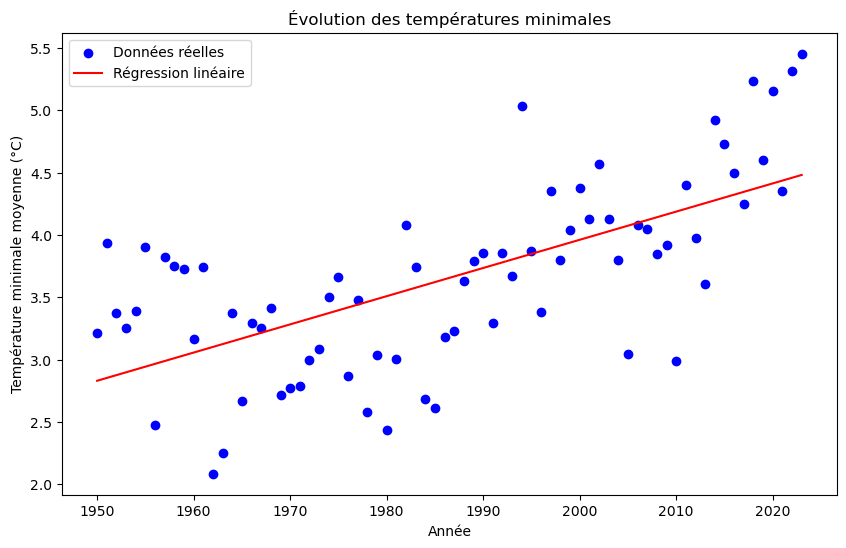

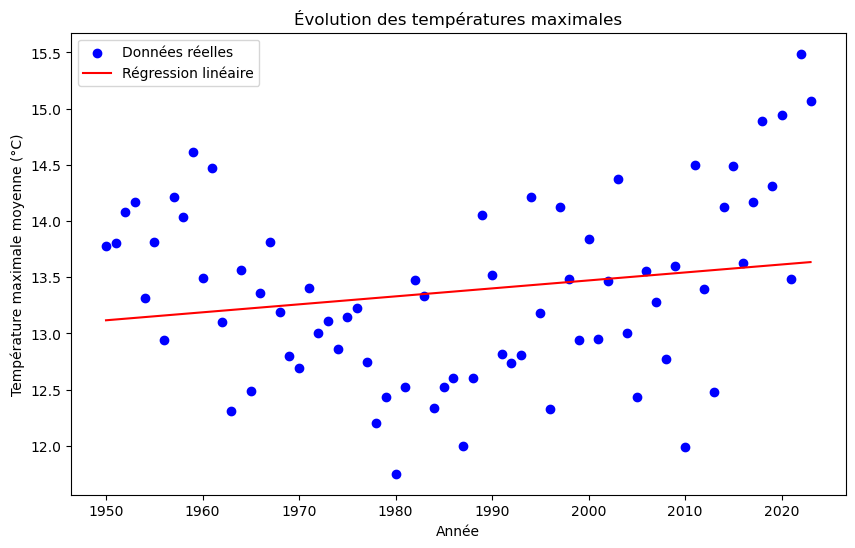

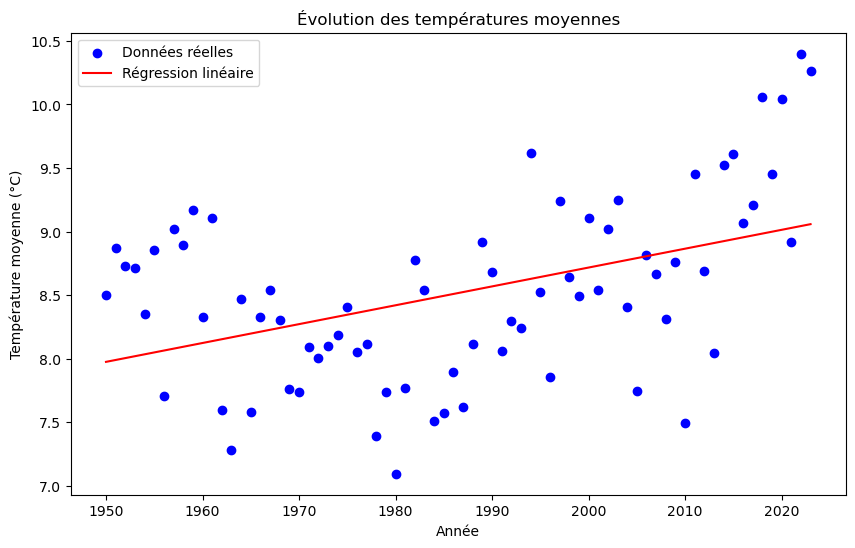

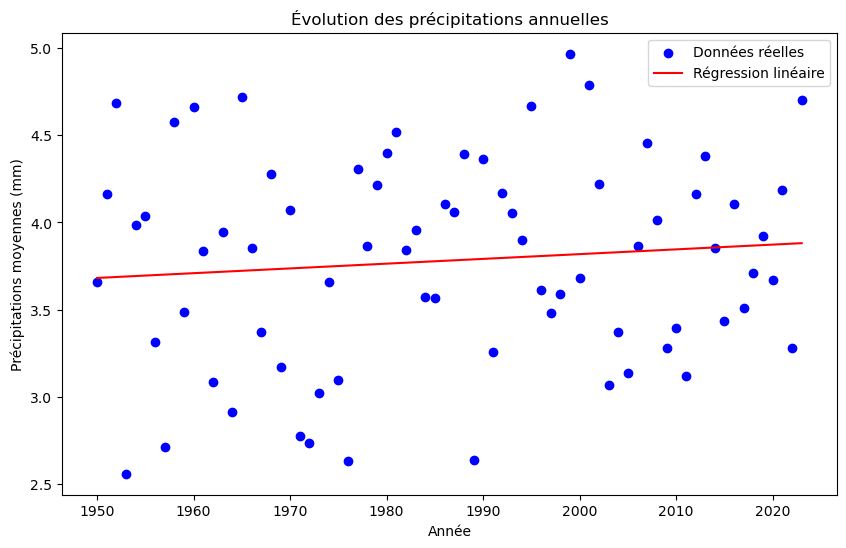

In [26]:
# Visualisation des températures minimales
plt.figure(figsize=(10, 6))
plt.scatter(X, y_tn, color='blue', label='Données réelles')
plt.plot(X, model_tn.predict(X), color='red', label='Régression linéaire')
plt.title("Évolution des températures minimales")
plt.xlabel("Année")
plt.ylabel("Température minimale moyenne (°C)")
plt.legend()
plt.show()

# Visualisation des températures maximales
plt.figure(figsize=(10, 6))
plt.scatter(X, y_tx, color='blue', label='Données réelles')
plt.plot(X, model_tx.predict(X), color='red', label='Régression linéaire')
plt.title("Évolution des températures maximales")
plt.xlabel("Année")
plt.ylabel("Température maximale moyenne (°C)")
plt.legend()
plt.show()

# Visualisation des températures maximales
plt.figure(figsize=(10, 6))
plt.scatter(X, y_temp, color='blue', label='Données réelles')
plt.plot(X, model_temp.predict(X), color='red', label='Régression linéaire')
plt.title("Évolution des températures moyennes")
plt.xlabel("Année")
plt.ylabel("Température moyenne (°C)")
plt.legend()
plt.show()

# Visualisation des précipitations
plt.figure(figsize=(10, 6))
plt.scatter(X, y_rr, color='blue', label='Données réelles')
plt.plot(X, model_rr.predict(X), color='red', label='Régression linéaire')
plt.title("Évolution des précipitations annuelles")
plt.xlabel("Année")
plt.ylabel("Précipitations moyennes (mm)")
plt.legend()
plt.show()

<h3>5) Evaluation de la performance des modèles de prédiction</h3>

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fonction pour afficher les métriques
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Évaluation du modèle {model_name} :")
    print(f" - MSE : {mse:.2f}")
    print(f" - MAE : {mae:.2f}")
    print(f" - R²  : {r2:.2f}")
    print()

# Prédictions des modèles
y_tn_pred = model_tn.predict(X)
y_tx_pred = model_tx.predict(X)
y_temp_pred = model_temp.predict(X)
y_rr_pred = model_rr.predict(X)

# Évaluation des modèles
evaluate_model(y_tn, y_tn_pred, "Températures minimales")
evaluate_model(y_tx, y_tx_pred, "Températures maximales")
evaluate_model(y_temp, y_temp_pred, "Températures moyennes")
evaluate_model(y_rr, y_rr_pred, "Précipitations")

Évaluation du modèle Températures minimales :
 - MSE : 0.32
 - MAE : 0.45
 - R²  : 0.42

Évaluation du modèle Températures maximales :
 - MSE : 0.61
 - MAE : 0.64
 - R²  : 0.04

Évaluation du modèle Températures moyennes :
 - MSE : 0.41
 - MAE : 0.53
 - R²  : 0.20

Évaluation du modèle Précipitations :
 - MSE : 0.34
 - MAE : 0.49
 - R²  : 0.01



<h4> Températures minimales avec R2=0.42 </h4> 
<b>Interprétation</b> : Le modèle explique environ 42 % de la variance des températures minimales, ce qui indique une relation linéaire modérée entre l’année et les températures minimales. <br />
<b>Analyse</b> : Bien que ce score ne soit pas excellent, il montre que le modèle parvient à capter une tendance générale. Cependant, un R² de 0.42 suggère que d’autres facteurs influencent fortement les températures minimales, comme l’humidité, la couverture nuageuse ou les variations saisonnières.<br />
<b>Conclusion</b> : La régression linéaire capte une partie de la tendance, mais elle pourrait être améliorée en intégrant d’autres variables explicatives ou en testant des modèles plus avancés, comme les modèles de séries temporelles ou les algorithmes non linéaires.

<h4>Températures maximales avec R2=0.04</h4>
<b>Interprétation</b> : Le modèle n’explique que 4 % de la variance des températures maximales, indiquant une relation linéaire extrêmement faible avec l’année. <br/>
<b>Analyse</b> : Ce faible score de R² montre que les températures maximales ne suivent pas une tendance linéaire claire. Elles peuvent être influencées par des facteurs plus complexes comme les épisodes de canicule, les variations de pression atmosphérique ou d’autres phénomènes météorologiques imprévisibles. <br/>
<b>Conclusion</b> : La régression linéaire est inadaptée pour ce type de données. L’exploration de modèles non linéaires ou de méthodes de séries temporelles intégrant des données météorologiques complémentaires pourrait être plus efficace.

<h4>Températures moyennes avec R2=0.20</h4>
<b>Interprétation</b> : Avec un R² de 20 %, le modèle ne parvient à expliquer qu’une faible part des variations des températures moyennes. <br/>
<b>Analyse</b> : Ce score indique que la relation entre l’année et les températures moyennes est relativement faible. Comme pour les températures maximales, d’autres variables climatiques, comme l’humidité ou la pression atmosphérique, pourraient jouer un rôle plus important. <br/>
<b>Conclusion</b> : L’approche linéaire est insuffisante pour bien modéliser les températures moyennes. Il serait pertinent d’essayer des modèles plus sophistiqués intégrant des variables climatiques supplémentaires.

<h4>Précipitations avec R2=0.01</h4>
<b>Interprétation</b> : Seulement 1 % de la variance des précipitations est expliquée par l'année. Cela indique que la régression linéaire est pratiquement inutile pour ces données.<br/>
<b>Analyse</b> : Les précipitations sont souvent très variables, et une relation linéaire avec le temps est rarement pertinente. Ces résultats confirment que d'autres méthodes (analyse de la variabilité saisonnière ou stochastique) seraient nécessaires.<br/>
<b>Conclusion</b> : La régression linéaire n'est pas pertinente pour les précipitations. Un modèle de série temporelle ou une étude approfondie des variations météorologiques pourrait mieux expliquer les données.

<h3>6) d'autre modèle plus pertinent qu’une régression linéaire</h3>

<h4>Forêt Aléatoire</h4>

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Modèle pour les températures maximales
rf_tx = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tx.fit(X, y_tx)
y_tx_rf_pred = rf_tx.predict(X)

# Modèle pour les températures minimales
rf_tn = RandomForestRegressor(n_estimators=100, random_state=42)
rf_tn.fit(X, y_tn)
y_tn_rf_pred = rf_tn.predict(X)

rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X, y_temp)
y_temp_rf_pred = rf_temp.predict(X)

rf_rr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rr.fit(X, y_rr)
y_rr_rf_pred = rf_rr.predict(X)

# Évaluation
print(f"R² pour les températures maximales (forêt aléatoire) : {r2_score(y_tx, y_tx_rf_pred):.2f}")
print(f"R² pour les températures minimales (forêt aléatoire) : {r2_score(y_tn, y_tn_rf_pred):.2f}")
print(f"R² pour les températures moyenne (forêt aléatoire) : {r2_score(y_temp, y_temp_rf_pred):.2f}")
print(f"R² pour les Précipitations (forêt aléatoire) : {r2_score(y_rr, y_rr_rf_pred):.2f}")


R² pour les températures maximales (forêt aléatoire) : 0.87
R² pour les températures minimales (forêt aléatoire) : 0.92
R² pour les températures moyenne (forêt aléatoire) : 0.89
R² pour les Précipitations (forêt aléatoire) : 0.79


<b>on peux remarquer que R2 raproche de la valeur 1 donc le model de la Forêt Aléatoire est plus pertinent</b>

### Prévisions

Quelle température fera-t-il en 2100 selon le modèle ?


In [29]:
X_2100 = [[2100]]
temp_2100_pred = rf_temp.predict(X_2100)

In [30]:
temp_2100_pred

array([10.04503647])

selon le modele en 2100 il fera <b>9.17325423</b> degree

### Variabilité saisonnière 

In [35]:
moyenne_mensuelle = meteo_cleaned.groupby('mois').agg({
    'TX': 'mean',  # Température maximale moyenne
    'TN': 'mean',  # Température minimale moyenne
    'RR': 'mean'   # Précipitations moyennes
}).reset_index()


In [36]:
moyenne_mensuelle.head()

,mois,TX,TN,RR
0,1,3.322224,-3.693531,3.851933
1,2,5.252906,-3.163189,3.638250
2,3,9.099777,-0.600451,3.421936
3,4,13.012858,2.448731,3.333708
4,5,17.906883,6.842077,3.835113


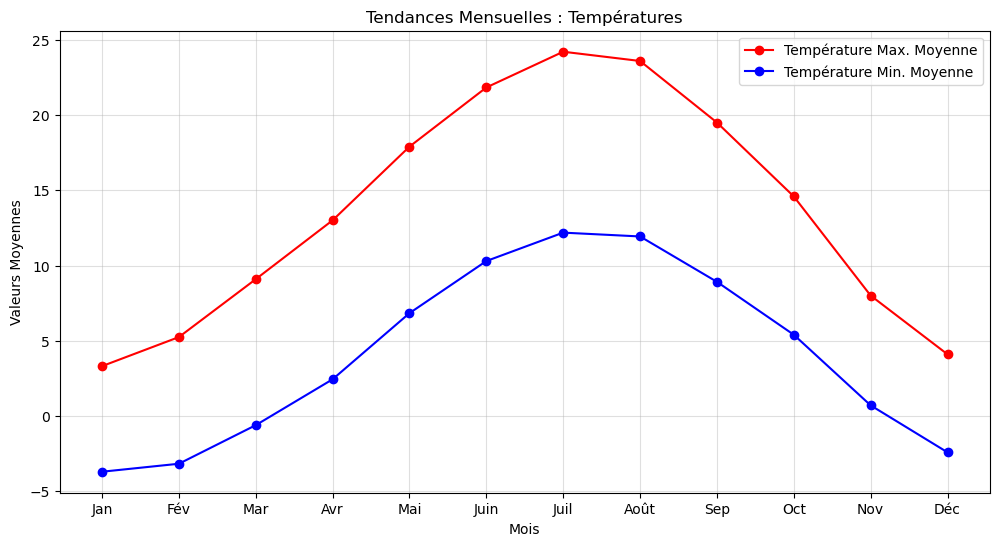

In [37]:
# Configuration du graphique
plt.figure(figsize=(12, 6))

# Températures maximales et minimales
plt.plot(moyenne_mensuelle['mois'], moyenne_mensuelle['TX'], label='Température Max. Moyenne', color='red', marker='o')
plt.plot(moyenne_mensuelle['mois'], moyenne_mensuelle['TN'], label='Température Min. Moyenne', color='blue', marker='o')


# Esthétique
plt.title("Tendances Mensuelles : Températures")
plt.xlabel("Mois")
plt.ylabel("Valeurs Moyennes")
plt.xticks(range(1, 13), [
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 
    'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.legend()
plt.grid(alpha=0.4)
plt.show()

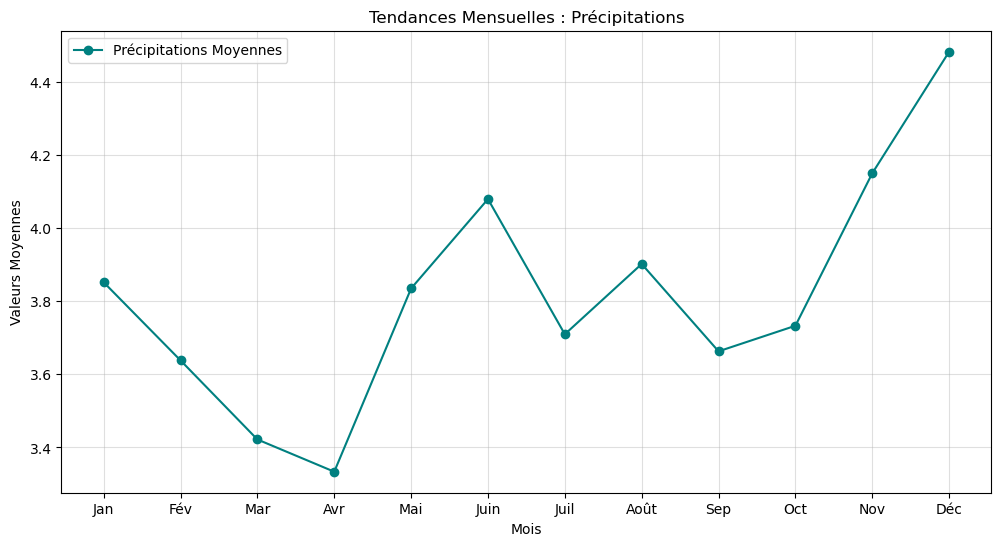

In [38]:
plt.figure(figsize=(12, 6))

# Températures maximales et minimales
plt.plot(moyenne_mensuelle['mois'], moyenne_mensuelle['RR'], label='Précipitations Moyennes', color='teal', marker='o')

# Esthétique
plt.title("Tendances Mensuelles : Précipitations")
plt.xlabel("Mois")
plt.ylabel("Valeurs Moyennes")
plt.xticks(range(1, 13), [
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 
    'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.legend()
plt.grid(alpha=0.4)
plt.show()

<h3>Identifier les tendances</h3>
<b>Températures</b> : Vous devriez observer un pic en été (juin à août) et des températures plus basses en hiver (décembre à février).<br/>
<b>Précipitations</b> : La distribution dépend de la région, mais en Haute-Savoie, les mois d'hiver et d'automne peuvent avoir des précipitations plus élevées (neige et pluie).

# PARTIE 2: Evolution des débits de l'Arve


Dans cet [article](https://doi.org/10.1038/s41598-020-67379-7), les autrices et les auteurs examinent l'impact du changement climatique et de la perte de masse des glaciers sur l'hydrologie du massif du Mont-Blanc, en particulier sur le bassin versant de la rivière Arve, qui est alimentée par une série de glaciers dans la région. Ils ont utilisé des projections climatiques (scénarios RCP4.5 et RCP8.5) et des simulations de dynamique des glaciers (historiques et futures) combinées a un modèle hydrologique pour étudier l'évolution du débit des rivières à l'échelle du 21e siècle (vus en cours).

Ci-dessous la zone d'étude de l'article avec en panneau (a), la localisation du bassin versant de Sallanches dans les Alpes françaises et la carte des bassins étudiés et en panneau (b), le massif du Mont-Blanc vu de Téléphérique de la Flégère (point noir avec angle de vue sur le plan).
![Zone étudiée: Fig 1 du papier](Fig1.png)


Dans leur article, ils commencent par étudier l'évolution des températures et des précipitations à Sallances. Ils montrent qu'il y a une nette augmentation des températures estivales et hivernales dans la région du Mont-Blanc et des modificaions de précipitations. Cela correspond à la figure 2 représentée ci-dessous.


![Fig 2 du papier](Fig2.png)



Dans cette partie, on va reproduire la figure n°3 du papier qui illustre l'évolution des débits saisonniers de la rivière Arve en fonction des scénarios climatiques. La figure présente des courbes pour les débits moyens (en hiver et en été) simulées sous les scénarios RCP4.5 et RCP8.5, à partir de différents modèles climatiques pour la région du Mont-Blanc.

## Chargement des données

Dans le dossier `Donnees_Debits/`, on dispose de données simulées historiques ainsi que de projections futures des débits cumulés (et de leur écart-type) de la rivière Arve (pour chaque scénario climatique). Ces données sont organisées en fonction des saisons (hiver, été ou moyenne annuelle) et des différents scénarios climatiques (historiques, RCP4.5, RCP8.5). 

**Modélisation climatique régionale et projections du débit de la rivière**

*Les deux scénarios RCP font partie des trajectoires d'émissions de gaz à effet de serre utilisées pour projeter les futurs changements climatiques. Dans le cadre de ces scénarios, plusieurs modèles climatiques régionaux ont été employés pour simuler l'évolution du climat, puis celle du débit de la rivière. Ces modèles sont spécifiques à chaque région et sont souvent "downscalés", c'est-à-dire affinés à une échelle régionale, afin de mieux représenter les conditions climatiques locales, comme celles du Mont Blanc. Le processus de downscaling permet ainsi d'obtenir des projections climatiques avec une résolution spatiale plus précise que celle des modèles climatiques globaux.* 


In [39]:
import os

# Dossier contenant les fichiers
data_folder = "Donnees_Debits/"

# Fonction 1 : Chargement des fichiers selon le scénario et la saison
def load_files(scenario, season):
    """
    Charge les fichiers correspondant au scénario et à la saison donnés.
    :param scenario: Scénario climatique ("historic", "rcp45", "rcp85").
    :param season: Saison ("hiver", "ete", "annuele").
    :return: Deux DataFrames (cumulé et SD).
    """
    # Construire les noms de fichiers
    cum_file = f"Donnees_Debits/Q_cum_{scenario}_{season}_multimodeles_OK"
    sd_file = f"Donnees_Debits/Q_sd_{scenario}_{season}_multimodeles_OK"

    # Charger les fichiers

    cum_data = pd.read_csv(cum_file, sep=',', parse_dates=['Date'])
    sd_data = pd.read_csv(sd_file, sep=',', parse_dates=['Date'])

    return cum_data, sd_data

## Analyse et création de fonctions

**Étant donnée une saison, la fonction calcule, pour chaque scénario (historique ou RCP), la moyenne et l'écart-type moyen du débit pour chaque année. Dans un second temps, on charge les données observées et on extrait la valeur pour la saison considérée. Puis, on reproduit les graphiques montrant l'évolution du débit moyen pour les saisons d'hiver et d'été, sous les deux scénarios RCP4.5 et RCP8.5.**



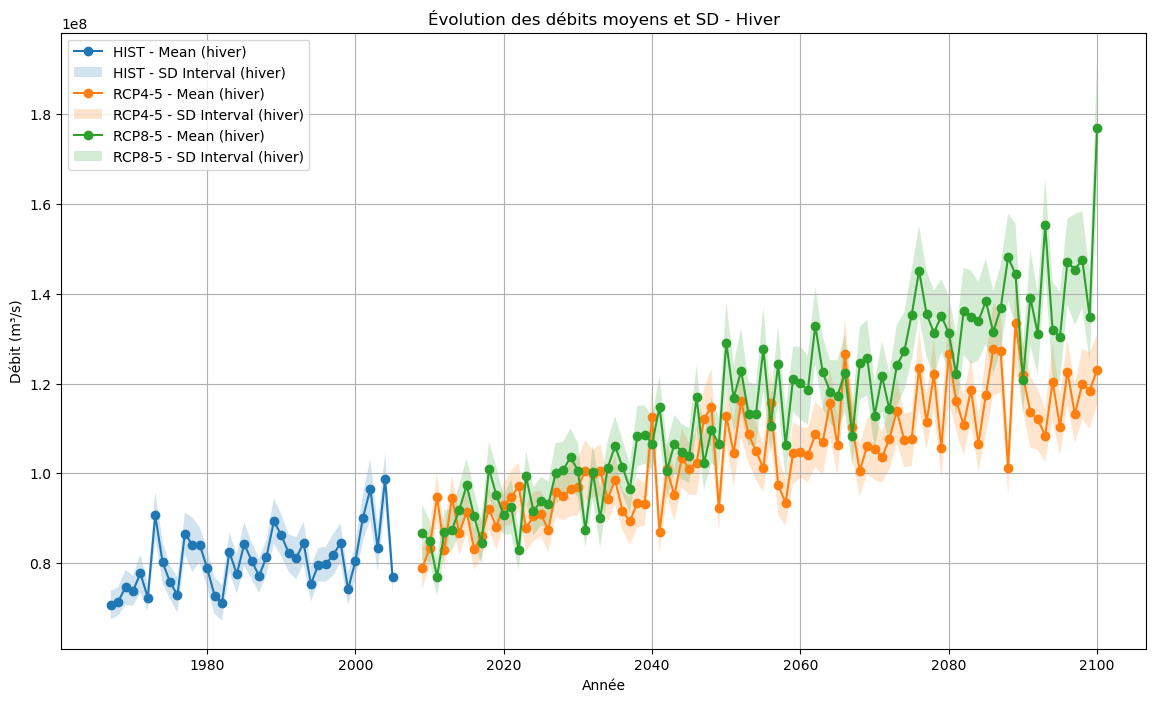

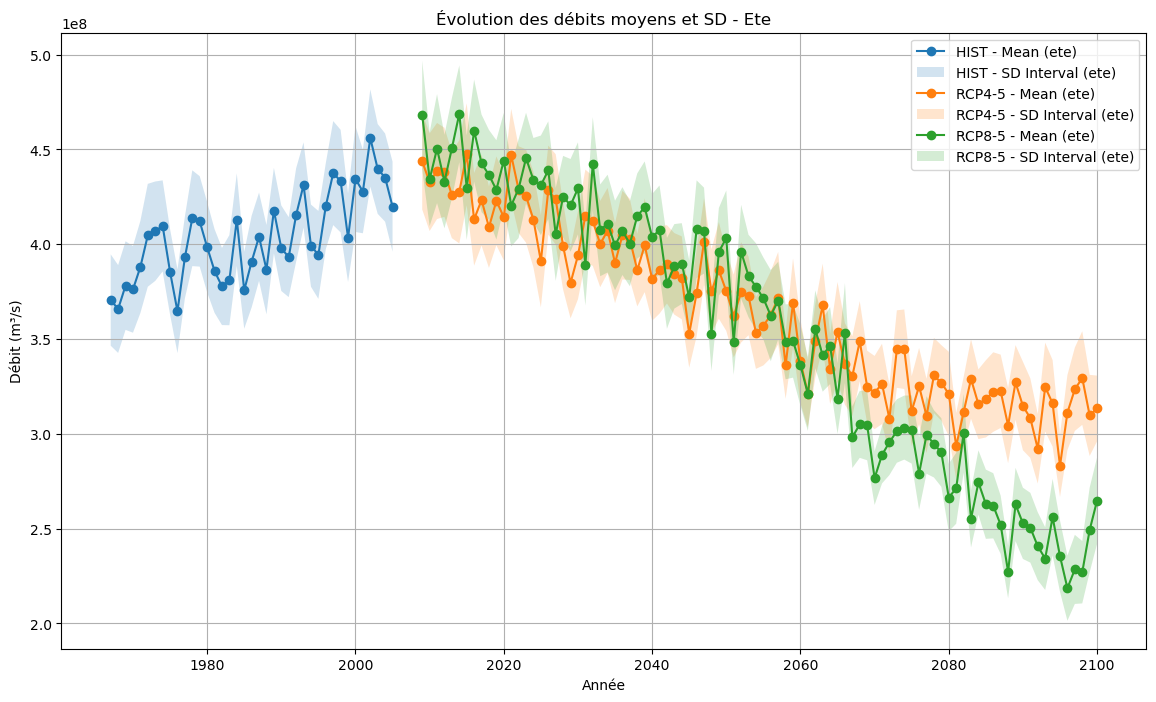

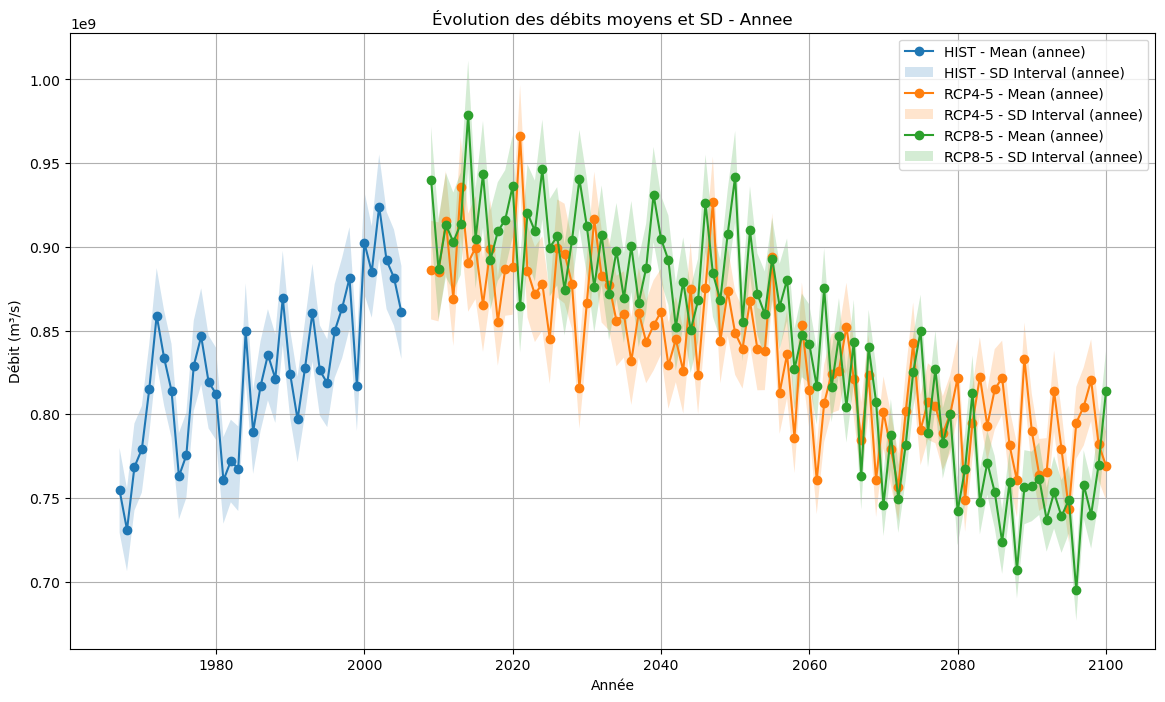

In [40]:
# Fonction 2 : Visualisation selon le scénario et la saison
def visualize_discharge(scenario, season):
    """
    Visualise les débits moyens et SD pour un scénario et une saison donnés.
    :param scenario: Scénario climatique ("historic", "rcp45", "rcp85").
    :param season: Saison ("hiver", "ete", "annuele").
    """
    # Charger les fichiers
    cum_data, sd_data = load_files(scenario, season)

  

    # Calcul des moyennes annuelles
    cum_data_annual = cum_data.groupby('Date').mean().reset_index()
    sd_data_annual = sd_data.groupby('Date').mean().reset_index()

    # Calculer la moyenne des colonnes de débit
    mean_discharge = cum_data_annual.iloc[:, 1:].mean(axis=1)
    sd_discharge = sd_data_annual.iloc[:, 1:].mean(axis=1)

    # Visualisation avec intervalle SD
    plt.figure(figsize=(12, 6))
    plt.plot(cum_data_annual['Date'], mean_discharge, label=f'{scenario.upper()} - Mean', linestyle='-', marker='o', color='blue')
    plt.fill_between(cum_data_annual['Date'], 
                     mean_discharge - 2 * sd_discharge, 
                     mean_discharge + 2 * sd_discharge, 
                     color='blue', alpha=0.2, label=f'{scenario.upper()} - SD Interval')
    plt.title(f'Évolution des débits moyens et SD ({season.capitalize()}) - {scenario.upper()}')
    plt.xlabel('Année')
    plt.ylabel('Débit (m³/s)')
    plt.legend()
    plt.grid()
    plt.show()

# Visualisation groupée par saison
def visualize_by_season(season):
    """
    Visualise les débits pour tous les scénarios dans une saison donnée.
    :param season: Saison ("hiver", "ete", "annuele").
    """
    plt.figure(figsize=(14, 8))
    for scenario in ["hist", "RCP4-5", "RCP8-5"]:
        cum_data, sd_data = load_files(scenario, season)

        
        # Calcul des moyennes annuelles
        cum_data_annual = cum_data.groupby('Date').mean().reset_index()
        sd_data_annual = sd_data.groupby('Date').mean().reset_index()

        # Calculer la moyenne des colonnes de débit
        mean_discharge = cum_data_annual.iloc[:, 1:].mean(axis=1)
        sd_discharge = sd_data_annual.iloc[:, 1:].mean(axis=1)

        # Ajouter les courbes avec intervalle SD
        plt.plot(cum_data_annual['Date'], mean_discharge, label=f'{scenario.upper()} - Mean ({season})', linestyle='-', marker='o')
        plt.fill_between(cum_data_annual['Date'], 
                         mean_discharge - 15 * sd_discharge, 
                         mean_discharge + 15 * sd_discharge, 
                         alpha=0.2, label=f'{scenario.upper()} - SD Interval ({season})')

    plt.title(f'Évolution des débits moyens et SD - {season.capitalize()}')
    plt.xlabel('Année')
    plt.ylabel('Débit (m³/s)')
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'utilisation
visualize_by_season("hiver")
visualize_by_season("ete")
visualize_by_season("annee")